In [1]:
import pandas as pd
from six.moves import urllib
import time
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 20)
pd.set_option('display.float_format', lambda x: "{0:,.3f}".format(x))

In [2]:
# Seattle house price index
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=SEXRNSA&scale=left&cosd=1990-01-01&coed=2018-12-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-03-22&revision_date=2019-03-22&nd=1990-01-01"

f = urllib.request.urlopen(url)
all_lines = f.read().decode('utf-8')

nested_alines = [line.split(',') for line in all_lines.split('\n')[1:]]
cols = all_lines.split('\n')[0].split(',')
adf = pd.DataFrame.from_records(nested_alines[:-1], columns=cols)
adf['DATE'] = pd.to_datetime(adf['DATE'])
adf['SEXRNSA'] = adf['SEXRNSA'].astype(float)
adf

,DATE,SEXRNSA
0,1990-01-01,58.233
1,1990-02-01,59.977
2,1990-03-01,62.294
3,1990-04-01,65.092
4,1990-05-01,66.825
5,1990-06-01,68.063
6,1990-07-01,68.299
7,1990-08-01,68.607
8,1990-09-01,68.134
9,1990-10-01,67.586


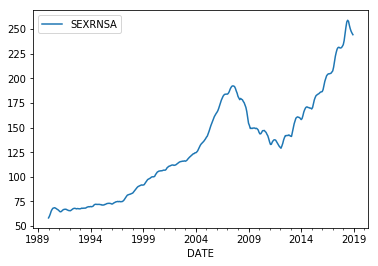

In [3]:
adf.set_index('DATE').plot()

In [4]:
# we invest same amount of money to both Real Estate and Stock market, to see the difference
every_year_investment = 12000.0

In [5]:
# Assume interset rate is 4.5% for 30-year fixed 
# https://www.bankrate.com/finance/mortgages/current-interest-rates.aspx

# We are going to spend $1000 a month, $12,000 a year. How much loan get we get?
loan_amount = np.pv(0.045, 30, -every_year_investment, 0)
loan_amount

195466.662531466

In [6]:
# assume we put 20% down, and loan 80%
# the home we can afford is

home_price = loan_amount/0.8
home_price

244333.3281643325

In [7]:
# Assume we buy the property in 1990, and now is 2018. 
# What's the home value now?
purchase_index = adf.iloc[0]["SEXRNSA"]
print("Purchase Index: {0:.3f}".format(purchase_index))
current_index = adf.iloc[-1]["SEXRNSA"]
print("Current Index: {0:.3f}".format(current_index))

current_value = home_price/purchase_index*current_index
print("Current Value: {0:,.2f}".format(current_value))

Purchase Index: 58.233
Current Index: 244.284
Current Value: 1,024,958.76


In [8]:
# property tax, assuming 0.8%
property_tax_rate = 0.008

purchase_index = adf.iloc[0]["SEXRNSA"]
adf['Year'] = adf['DATE'].map(lambda x:x.year)
average_home_value_per_year = adf.groupby('Year')['SEXRNSA'].agg(['mean'])
average_home_value_per_year['PropertyTax'] = home_price / purchase_index * average_home_value_per_year['mean']*property_tax_rate
average_home_value_per_year

,mean,PropertyTax
Year,,
1990,65.531,"2,199.613"
1991,65.972,"2,214.422"
1992,67.135,"2,253.470"
1993,68.522,"2,300.014"
1994,71.230,"2,390.904"
1995,72.241,"2,424.854"
1996,74.108,"2,487.501"
1997,79.772,"2,677.618"
1998,88.663,"2,976.068"


In [9]:
# total property tax
total_property_tax = average_home_value_per_year.sum()
total_property_tax

mean            3,765.106
PropertyTax   126,379.879
dtype: float64

In [10]:
total_expense = (-average_home_value_per_year["PropertyTax"] + (-every_year_investment)).tolist()
irr_table = np.append(total_expense, current_value)
print(irr_table)
print("Internal Return Rate: {0:.2f}%".format(np.irr(irr_table)*100))

[ -14199.61254291  -14214.42151901  -14253.46951862  -14300.01405847
  -14390.90403095  -14424.85377028  -14487.50140704  -14677.61773247
  -14976.06818468  -15240.28994942  -15505.34959636  -15690.5579924
  -15841.46889888  -16036.85531497  -16422.4547464   -17118.46278264
  -17939.72590819  -18334.68697655  -17867.67065736  -17025.69865621
  -16846.40205885  -16527.21074815  -16623.7741078   -17167.28663865
  -17607.25682741  -18050.10233316  -18703.23116539  -19558.77610427
  -20348.15467437 1024958.76236618]
Internal Return Rate: 4.97%


# How about rent?

## Assuming: 
- No HOA
- No home insurance
- Perfect renter and no gaps
- No any fixes

In [11]:
rent_captalization_rate = 0.04 # 1M home rent for 40k a year, 3.3k/month
income_tax_rate = 0.24 # rent income is taxed at edge (MFJ, Taxable Income between 165k and 315k)
average_home_value_per_year['Rent'] = home_price / purchase_index * average_home_value_per_year['mean'] \
                                      *rent_captalization_rate*(1-income_tax_rate)
average_home_value_per_year

,mean,PropertyTax,Rent
Year,,,
1990,65.531,"2,199.613","8,358.528"
1991,65.972,"2,214.422","8,414.802"
1992,67.135,"2,253.470","8,563.184"
1993,68.522,"2,300.014","8,740.053"
1994,71.230,"2,390.904","9,085.435"
1995,72.241,"2,424.854","9,214.444"
1996,74.108,"2,487.501","9,452.505"
1997,79.772,"2,677.618","10,174.947"
1998,88.663,"2,976.068","11,309.059"


In [12]:
# if we sell the home
# 6% agent fee (you pay both buyer and seller agent), 1.78% transfer tax, 15% long term captial gain
gross_proceed = (current_value * (1-0.06-0.0178))
tax = (gross_proceed - home_price) * 0.15
net_proceed = gross_proceed - tax
print (net_proceed)
irr_table[-1] = net_proceed + average_home_value_per_year.sum()['Rent']
print(irr_table)
print("Internal Return Rate: {0:.2f}%".format(np.irr(irr_table)*100))

840084.4242806272
[ -14199.61254291  -14214.42151901  -14253.46951862  -14300.01405847
  -14390.90403095  -14424.85377028  -14487.50140704  -14677.61773247
  -14976.06818468  -15240.28994942  -15505.34959636  -15690.5579924
  -15841.46889888  -16036.85531497  -16422.4547464   -17118.46278264
  -17939.72590819  -18334.68697655  -17867.67065736  -17025.69865621
  -16846.40205885  -16527.21074815  -16623.7741078   -17167.28663865
  -17607.25682741  -18050.10233316  -18703.23116539  -19558.77610427
  -20348.15467437 1320327.96410777]
Internal Return Rate: 6.46%


# How about stock?

In [5]:
from yqd import *

# 'https://query1.finance.yahoo.com/v7/finance/download/^GSPC?period1=-630950400&period2=1551686400&interval=1d&events=history&crumb=7yeobYpz5RM'
quote = load_yahoo_quote('^GSPC', '19900101', '20181201', 'quote', 'dataframe')
quote['Year'] = quote['Date'].map(lambda x:x.year)
quote

,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,1990-01-02,353.400,359.690,351.980,359.690,359.690,162070000,1990
1,1990-01-03,359.690,360.590,357.890,358.760,358.760,192330000,1990
2,1990-01-04,358.760,358.760,352.890,355.670,355.670,177000000,1990
3,1990-01-05,355.670,355.670,351.350,352.200,352.200,158530000,1990
4,1990-01-08,352.200,354.240,350.540,353.790,353.790,140110000,1990
5,1990-01-09,353.830,354.170,349.610,349.620,349.620,155210000,1990
6,1990-01-10,349.620,349.620,344.320,347.310,347.310,175990000,1990
7,1990-01-11,347.310,350.140,347.310,348.530,348.530,154390000,1990
8,1990-01-12,348.530,348.530,339.490,339.930,339.930,183880000,1990
9,1990-01-15,339.930,339.940,336.570,337.000,337.000,140590000,1990


In [14]:
def find_purchase_price(quote):
   
    aggregation =  {
        'Adj Close':  [
                       np.random.choice # Doesn't care, random pick a day to invest
                      ]
        }
    
    
    every_year = quote.groupby('Year').agg(aggregation)
    every_year.columns = every_year.columns.get_level_values(1)
    every_year.reset_index()
    # the renaming in aggregation dict is deprecated, explicitly rename here:
    every_year.columns = ['Rand']
    return every_year

def invest(amount, purchase_pricing):
    purchase_pricing = every_year.join(average_home_value_per_year, on="Year")
    purchase_pricing['TotalSpent'] = amount+purchase_pricing['PropertyTax']
    purchase_pricing['RandShare'] = purchase_pricing['TotalSpent']/purchase_pricing['Rand']
    return purchase_pricing

def get_irr(data, final_value):
    investment_table = np.append((-data['TotalSpent']).tolist(), final_value)
    print(investment_table)
    return np.irr(investment_table)*100

   
def calc_dividend(row):
    return row["RandShare"]*1.01**(2019-int(row.name))

def add_dividend(every_year):
    every_year["RandShareWithDividend"] = every_year.apply(calc_dividend, axis=1)

last_close = float(quote.tail(1)['Adj Close'])   

def get_result(every_year):
    today = every_year.sum()
    rand_value = today['RandShare']*last_close
    print ("Buy On Random Day: ${0:12,.2f}, Internal Return Rate:{1:.2f}%".format(rand_value, get_irr(every_year, rand_value)))

def get_value_with_dividend(every_year):
    today_with_dividend = every_year.sum()
    rand_value_with_dividen = today_with_dividend['RandShareWithDividend']*last_close
    print ("Buy On Random Day with dividend: ${0:12,.2f}, Internal Return Rate:{1:.2f}%".format(rand_value_with_dividen, get_irr(every_year, rand_value_with_dividen)))



In [15]:
# investment on stock
every_year = find_purchase_price(quote)
every_year = invest(every_year_investment, every_year)
add_dividend(every_year)

get_value_with_dividend(every_year)

[ -14199.61254291  -14214.42151901  -14253.46951862  -14300.01405847
  -14390.90403095  -14424.85377028  -14487.50140704  -14677.61773247
  -14976.06818468  -15240.28994942  -15505.34959636  -15690.5579924
  -15841.46889888  -16036.85531497  -16422.4547464   -17118.46278264
  -17939.72590819  -18334.68697655  -17867.67065736  -17025.69865621
  -16846.40205885  -16527.21074815  -16623.7741078   -17167.28663865
  -17607.25682741  -18050.10233316  -18703.23116539  -19558.77610427
  -20348.15467437 1687151.87727948]
Buy On Random Day with dividend: $1,687,151.88, Internal Return Rate:7.85%


In [16]:
quote['Month'] = quote['Date'].map(lambda x:x.month)

def calc_monthly_change(quote):
    first_day_of_each_month = quote.groupby(['Year', 'Month'])['Adj Close'].agg(['first'])
    first_day_of_each_month["change"] = first_day_of_each_month.pct_change(12)
    return first_day_of_each_month

def simulate_iul(change):
    if change < 0.0075:
        return 0.0075
    if change > 0.135:
        return 0.135
    return change

def get_iul_change(quote):
    first_day_of_each_month = calc_monthly_change(quote)
    first_day_of_each_month["iul_mode"] = first_day_of_each_month['change'].apply(simulate_iul)
    return first_day_of_each_month

def calc_compond_cash_value(df):
    for i in range(13, len(df)):
        df.iloc[i]["cash_value"] = (1 + df.iloc[i]['iul_mode'])*df.iloc[i-12]['cash_value'] +  df.iloc[i]["cash_value"] 


def invest_on_iul(first_day_of_each_month):
    first_day_of_each_month["cash_value"] = every_year_investment/12*0.8 #assuming 20% cost of insurance (COI)
    first_day_of_each_month = first_day_of_each_month.copy()
    calc_compond_cash_value(first_day_of_each_month)
    return first_day_of_each_month

def calc_return(first_day_of_each_month):
    final_value = first_day_of_each_month.tail(12).sum()["cash_value"]
    investment_table = np.append(np.full(len(every_year), -every_year_investment),final_value)
    iul_irr = np.irr(investment_table)*100
    print ("IUL mode: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(final_value, iul_irr))

pd.set_option("display.max_rows", 36)
first_day_of_each_month = get_iul_change(quote)
after_investment = invest_on_iul(first_day_of_each_month)
after_investment

first  change  iul_mode  cash_value
Year Month                                        
1990 1       359.690     nan       nan     800.000
     2       328.790     nan       nan     800.000
     3       332.740     nan       nan     800.000
     4       338.700     nan       nan     800.000
     5       332.250     nan       nan     800.000
     6       363.160     nan       nan     800.000
     7       359.540     nan       nan     800.000
     8       355.520     nan       nan     800.000
     9       323.090     nan       nan     800.000
     10      314.940     nan       nan     800.000
     11      307.020     nan       nan     800.000
     12      324.100     nan       nan     800.000
1991 1       326.450  -0.092     0.007     800.000
     2       343.050   0.043     0.043   1,634.697
     3       370.470   0.113     0.113   1,690.713
     4       371.300   0.096     0.096   1,677.000
     5       380.290   0.145     0.135   1,708.000
     6       388.060   0.069     0.069   1,654.852
...              ...     ...       ...         ...
2017 6     2,430.060   0.158     0.135  79,237.190
     7     2,429.010   0.155     0.135  73,447.425
     8     2,476.350   0.141     0.135  88,146.642
     9     2,476.550   0.141     0.135  92,282.320
     10    2,529.120   0.170     0.135  83,879.370
     11    2,579.360   0.221     0.135  84,171.227
     12    2,642.220   0.206     0.135  81,400.157
2018 1     2,695.810   0.194     0.135  81,400.573
     2     2,821.980   0.238     0.135  90,483.764
     3     2,677.670   0.118     0.118  87,373.875
     4     2,581.880   0.095     0.095  88,126.799
     5     2,654.800   0.112     0.112  92,130.786
     6     2,734.620   0.125     0.125  89,968.008
     7     2,726.710   0.123     0.123  83,249.156
     8     2,813.360   0.136     0.135 100,846.439
     9     2,896.720   0.170     0.135 105,540.433
     10    2,924.590   0.156     0.135  96,003.085
     11    2,740.370   0.062     0.062  90,225.402

[347 rows x 4 columns]

In [17]:
calc_return(after_investment)

IUL mode: $1,086,748.48, Interal Return Rate:6.83%
